In [1]:
import numpy as np
import scipy.special as sp

RED = "\033[91m"
GREEN = "\033[92m"
BLUE = "\033[94m"
RESET = "\033[0m"  # Reset to default color

In [7]:
def _compute_a_b_p_d(
    k1: float,
    L_2D: float,
    z_i: float,
    psi_rad: float,
) -> tuple[float, float, float, float]:
    """
    Compute the constants a, b, p, d for use in F11 and F22 formulae
    """
    square_L2D = np.power(L_2D, 2)
    square_z_i = np.power(z_i, 2)
    square_cos_psi_rad = np.power(np.cos(psi_rad), 2)

    common = 2 * np.power(k1, 2) * square_cos_psi_rad

    a = 1 + (common * square_L2D)
    b = 1 + (common * square_z_i)

    p = (square_L2D * b) / (square_z_i * a)
    d = (square_L2D / square_z_i) - 1

    return a, b, p, d

## F11 Implementation

In [15]:
def analytic_F11_2d(
    k1: float,
    c: float,
    L_2D: float,
    z_i: float,
    psi_rad: float,
    do_print: bool = True,
) -> float:
    """
    Analytic solution for F11(k1)

    Default values are to replicate Fig 2 in the simulation paper
    """
    if do_print:
        print(f"{BLUE}")
        print(" F11 inputs, k1: ", k1, " L_2D: ", L_2D, " z_i: ", z_i, " psi_rad: ", psi_rad)

    L_2D /= 1000.0 # Convert to km

    ############################################################
    # CONSTANTS
    a, b, p, d = _compute_a_b_p_d(k1, L_2D, z_i, psi_rad)
    
    if do_print:
        print(" -- a: ", a)
        print(" -- b: ", b)
        print(" -- p: ", p)
        print(" -- d: ", d)

    ############################################################

    # First term
    first_term_factor = (
        sp.gamma(11/6) * (np.power(L_2D, (11/6)))
    ) / (
        10 * np.sqrt(2 * np.pi) * sp.gamma(7/3) * (L_2D**2 - z_i**2) * np.sin(psi_rad)**3 * a**(5/6)
    )

    alpha = sp.hyp2f1(5/6, 1, 1/2, p)
    beta = sp.hyp2f1(-1/6, 1, 1/2, p)

    if do_print:
        print(" -- first_term_factor: ", first_term_factor)
        print(" -- hyp eval at (5/6, 1, 1/2, p): ", alpha)
        print(" -- hyp eval at (-1/6, 1, 1/2, p): ", beta)

    first_term_paren = (2 * beta) - ((p + 7) * alpha)
    first_term = first_term_factor * first_term_paren

    if do_print:
        print(" -- first_term_paren: ", first_term_paren)
        print(" first_term: ", first_term)

    # Second term
    second_term_numerator = np.power(np.cbrt(L_2D), 14) * np.sqrt(b)
    assert not np.iscomplexobj(second_term_numerator), "second_term_numerator is complex"

    second_term_denominator = (2 * np.sqrt(2)) * np.power(np.cbrt(d), 7) * np.power(z_i, 3) * np.power(np.sin(psi_rad), 3)
    if do_print:
        print(" -- second_term_numerator: ", second_term_numerator)
        print(" -- second_term_denominator: ", second_term_denominator)

    second_term = second_term_numerator / second_term_denominator

    # second_term = (
    #     L_2D ** (14 / 3) * np.sqrt(b)
    # ) / (
    #     2 * np.sqrt(2) * d ** (7 / 3) * (z_i * np.sin(psi_rad)) ** 3
    # )

    if do_print:
        print(" second_term: ", second_term)
    
    result = c * (first_term + second_term)
    if do_print:
        print(f"{RESET}")
        print("result: ", result)
    return result

## F11 Trial w/ single value

In [12]:
###################################
# Figure 1 parameters

c = 1.0
L_2D = 20_000.0 # [m]
z_i = 500.0 # [m]
psi_rad = np.deg2rad(43.0)
###################################

k1_test = 1.0 / L_2D
analytic_F11_2d(
    k1_test, 
    c, 
    L_2D, 
    z_i, 
    psi_rad,
    do_print=True,
)

# print(hyp_five_sixth_(0.016000000010680448))
# k1_test_vals = np.array([1/1000, 1/100, 1/10, 1, 10, 100, 1000]) / L_2D

# k1F11_values = np.array([
#     k * analytic_F11_2d(k, c, L_2D, z_i, psi_rad) for k in k1_test_vals
# ])



 F11 inputs, k1:  5e-08  L_2D:  20000.0  z_i:  500.0  psi_rad:  0.7504915783575618
 -- a:  1.0000000000010698
 -- b:  1.0000000006685978
 -- p:  0.0016000000010680448
 -- d:  -0.9984
 -- first_term_factor:  -9.664684602693859e-05
 -- hyp eval at (5/6, 1, 1/2, p):  1.0026718909560657
 -- hyp eval at (-1/6, 1, 1/2, p):  0.9994661920352677
 -- first_term_paren:  -5.0213751276485254
 first_term:  0.00048530006880534616
 -- second_term_numerator:  1178890.0799590263
 -- second_term_denominator:  -111733224.70476137
 second_term:  -0.0105509357943805

result:  -0.010065635725575154


-0.010065635725575154

## F11 Plotting

In [13]:
k1_times_L2D = np.logspace(-4, 4, 500)
k1 = k1_times_L2D / L_2D

k1F11_values = np.array([
    k * analytic_F11_2d(k, c, L_2D, z_i, psi_rad, do_print=False) for k in k1
])

# print(" k1F11_values: ", k1F11_values)

 -- a:  1.0000000000000107
 -- b:  1.000000000006686
 -- p:  0.0016000000000106803
 -- d:  -0.9984
 -- a:  1.0000000000000115
 -- b:  1.0000000000071982
 -- p:  0.0016000000000114987
 -- d:  -0.9984
 -- a:  1.0000000000000124
 -- b:  1.0000000000077498
 -- p:  0.0016000000000123797
 -- d:  -0.9984
 -- a:  1.0000000000000133
 -- b:  1.0000000000083438
 -- p:  0.0016000000000133288
 -- d:  -0.9984
 -- a:  1.0000000000000144
 -- b:  1.000000000008983
 -- p:  0.0016000000000143497
 -- d:  -0.9984
 -- a:  1.0000000000000155
 -- b:  1.0000000000096714
 -- p:  0.001600000000015449
 -- d:  -0.9984
 -- a:  1.0000000000000167
 -- b:  1.0000000000104123
 -- p:  0.001600000000016633
 -- d:  -0.9984
 -- a:  1.000000000000018
 -- b:  1.0000000000112101
 -- p:  0.0016000000000179074
 -- d:  -0.9984
 -- a:  1.0000000000000193
 -- b:  1.0000000000120692
 -- p:  0.00160000000001928
 -- d:  -0.9984
 -- a:  1.0000000000000209
 -- b:  1.000000000012994
 -- p:  0.0016000000000207573
 -- d:  -0.9984
 -- a:  

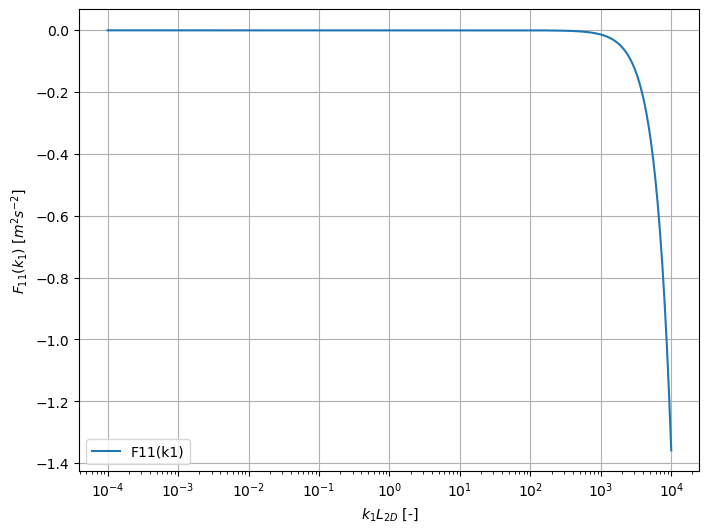

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(k1_times_L2D, k1F11_values, '-', label="F11(k1)")
plt.xscale('log')
plt.grid(True)
plt.xlabel('$k_1 L_{2D}$ [-]')
plt.ylabel('$F_{11}(k_1)$ [$m^2s^{-2}$]')
plt.legend()
plt.show()


In [103]:
x = -0.9984
print(x**(7/3))
print(np.power(np.cbrt(-0.9984), 7))
print(np.cbrt(x**7))
print(np.cbrt(np.power(x,7)))

(0.49813532409037437+0.862795690369318j)
-0.9962706481807497
-0.9962706481807493
-0.9962706481807493
